<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>2D drift/flow investigation </b></span><br>
<span style="font-size: 16px;">
- In this previous script 5_0, we observed larger inner flux in case of NT plasmas <br>
- I believe the reason is the position of inner legs. In NT plasmas, the inner leg is much closer to LFS <br>
- The structure of ExB (radial, poloidal) components will affect this strong inner heat flux
</span>
</div>



In [1]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator


from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from matplotlib.ticker import AutoMinorLocator

# For power quantification diagnostic
from gbspy.surfaces import get_line

# Get the current working directory|
cwd = os.getcwd()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# IEEE journals typically require figures to be very clear at a column width of around 3.5 to 4 inches
fig_width = 3.5  # in inches
fig_height = fig_width / 1.618  # Golden ratio height for a single subplot

plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (fig_width, fig_width / 1.618),  # IEEE column width, golden ratio height
    'figure.dpi': 300,                     # Figure resolution
    'savefig.dpi': 300,                    # Save figure resolution
    'savefig.format': 'pdf',               # Preferred format for vector graphics

    # Font settings
    'font.size': 10,                       # Main font size
    'font.family': 'sans-serif',           # Font family
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],  # Font type

    # Axes settings
    'axes.labelsize': 10,                  # Font size of the x and y labels
    'axes.titlesize': 10,                  # Font size of the title
    'axes.linewidth': 1,                   # Edge line width

    # Tick settings
    'xtick.labelsize': 8,                  # Font size of the x tick labels
    'ytick.labelsize': 8,                  # Font size of the y tick labels
    'xtick.major.size': 4,                 # Length of major tick marks
    'xtick.minor.size': 2,                 # Length of minor tick marks
    'xtick.major.width': 1,                # Width of major tick marks
    'xtick.minor.width': 0.5,              # Width of minor tick marks
    'ytick.major.size': 4,                 # Length of major tick marks
    'ytick.minor.size': 2,                 # Length of minor tick marks
    'ytick.major.width': 1,                # Width of major tick marks
    'ytick.minor.width': 0.5,              # Width of minor tick marks

    # Legend settings
    'legend.fontsize': 8,                  # Font size of the legend
    'legend.frameon': True,               # Disable background frame
    'legend.edgecolor':'white',

    # Line settings
    'lines.linewidth': 1.5,                # Line width
    'lines.markersize': 5,                 # Marker size

    # Grid settings
    'grid.alpha': 0.5,                     # Grid line transparency
    'grid.linestyle': ':',                 # Grid line style

})


<div class="alert alert-block alert-info"  style="text-align: center;">
<span style="font-size: 40px;"><b> NT -0.6 </b></span><br>
</div>

In [64]:
os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/delta_scan/DNT_dn0p6')

# Load GBS simulations
s=g.Sim()

t2= s.time[-1]-1
t1= t2

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]


dens  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_avg_tor = np.mean(dens, axis=2)
dens_fluct   = dens[:,:,0,:]-dens_avg_tor

phi   = s.get_field('strmf', z1=z1, z2=z2, t1=t1, t2=t2)
phi_avg   = np.mean(phi, axis=(2,3))
phi_avg_tor = np.mean(phi, axis=2)


theta = s.get_field('theta',     z1=z1, z2=z2, t1=t1, t2=t2)
theta_avg  = np.mean(theta, axis=(2,3))

Te    = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
Te_avg    = np.mean(Te, axis=(2,3))


vpare = s.get_field('vpare', z1=z1, z2=z2, t1=t1, t2=t2)
vpare_avg = np.mean(vpare, axis=(2,3))

pe    = dens * Te
pe_avg  = np.mean(pe, axis=(2,3))

phi_diff_all_x = np.gradient(phi, s.dx, axis=1)
phi_diff_all_y = np.gradient(phi, s.dy, axis=0)
phi_avg_diff_x = np.gradient(phi_avg, s.dx, axis=1)
phi_avg_diff_y = np.gradient(phi_avg, s.dy, axis=0)

phi_fluct = phi[:,:,0,:]-phi_avg_tor
phi_fluct_diff_x = np.gradient(phi_fluct, s.dx, axis=1)
phi_fluct_diff_y = np.gradient(phi_fluct, s.dy, axis=0)

### ExB mean flux
Gamma_mean_ExB_R = bsign * dens_avg * phi_avg_diff_y
Gamma_mean_ExB_Z = -bsign * dens_avg * phi_avg_diff_x

### ExB fluctuating flux
Gamma_fluct_ExB_R = bsign * np.mean(dens_fluct* phi_fluct_diff_y, axis=2)
Gamma_fluct_ExB_Z = -bsign * np.mean(dens_fluct* phi_fluct_diff_x, axis=2)
Gamma_flcut_ExB_tot = Gamma_fluct_ExB_R + Gamma_fluct_ExB_Z

### Parallel flux
[v_par_x, v_par_y]=g.parallel_e_velocity(s, vpare)
vpare_x = np.mean(v_par_x, axis=(2,3))
vpare_y = np.mean(v_par_y, axis=(2,3))
Gamma_par_R = dens_avg * vpare_x
Gamma_par_Z = dens_avg * vpare_y

### Diamagnetic flux
pe_diff_x = np.gradient(pe_avg, s.dx, axis=1)
pe_diff_y = np.gradient(pe_avg, s.dy, axis=0)
Te_diff_x = np.gradient(Te_avg, s.dx, axis=1)
Te_diff_y = np.gradient(Te_avg, s.dy, axis=0)

theta_diff_x = np.gradient(theta_avg, s.dx, axis=1)
theta_diff_y = np.gradient(theta_avg, s.dy, axis=0)

#[v_de_x, v_de_y] = diamagnetic_e_velocity(s, theta_avg, Te_avg)
v_de_x = -bsign * (Te_diff_y + Te_avg * theta_diff_y)
v_de_y = bsign * (Te_diff_x + Te_avg * theta_diff_x)
Gamma_diamag_R = dens_avg * v_de_x
Gamma_diamag_Z = dens_avg * v_de_y


In [61]:
# For balanced DN
OMP_HFS_dn0p6=(s.x0-127, s.y0)
OMP_LFS_dn0p6=(s.x0+190, s.y0)

coord_HFS_dn0p6, length_HFS_dn0p6 = get_line(s, OMP_HFS_dn0p6, (-350,350), "chi", resolution=(40,40))
coord_LFS_dn0p6, length_LFS_dn0p6 = get_line(s, OMP_LFS_dn0p6, (-250,250), "chi", resolution=(40,40))

from scipy.interpolate import RectBivariateSpline
qpare_interpolant = RectBivariateSpline(s.y, s.x, qpare_DNT_dn0p6)
qpare_HFS_dn0p6 = qpare_interpolant(coord_HFS_dn0p6[1,:], coord_HFS_dn0p6[0,:], grid=False)
qpare_LFS_dn0p6 = qpare_interpolant(coord_LFS_dn0p6[1,:], coord_LFS_dn0p6[0,:], grid=False)


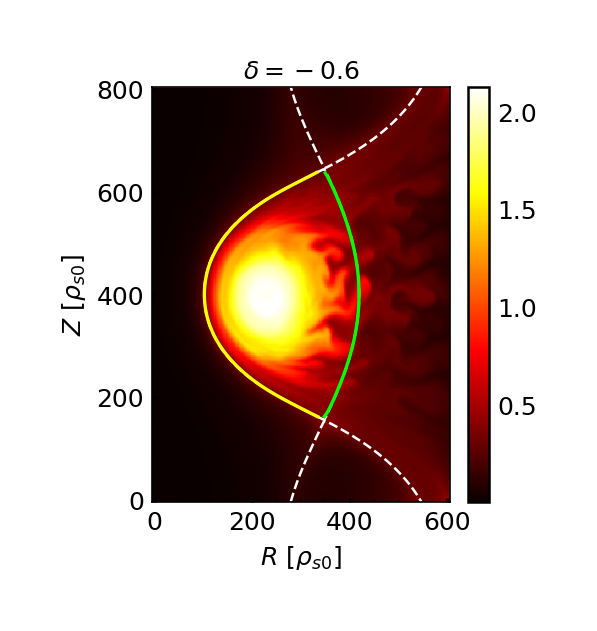

In [63]:
fig, ax = plt.subplots(figsize=(0.8,0.9), dpi=600)
X,Y = np.meshgrid(s.x, s.y)


cs=ax.pcolormesh(X, Y, dens_DNT_dn0p6[:,:,0,-1], cmap='hot', rasterized=True)

cbar = fig.colorbar(cs)

#cbar.ax.set_ylabel(r'Growth rate $\gamma$', fontsize=2, labelpad=1) # Colorbar y-label
cbar.ax.tick_params(labelsize=3, size=0, pad=1) 
cbar.outline.set_linewidth(0.3)


# Plot Separatrix
ax.contour(X, Y, Psi_NT_dn0p6, levels=[Psi_NT_dn0p6[iyxpt_NT_dn0p6, ixxpt_NT_dn0p6]], colors='w', linewidths=0.3, linestyles='--')

ax.plot(coord_HFS_dn0p6[0,:], coord_HFS_dn0p6[1,:], c='yellow', linestyle='-', linewidth=0.4)
ax.plot(coord_LFS_dn0p6[0,:], coord_LFS_dn0p6[1,:], c='lime', linestyle='-', linewidth=0.4)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', direction="in", size=0.2, width=0.2)
ax.tick_params(which='major', direction="in", size=0.5, width=0.4)
ax.tick_params(axis='x', labelsize=3, pad=1)
ax.tick_params(axis='y', labelsize=3, pad=1)
ax.yaxis.get_offset_text().set_fontsize(2.5)
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=3, labelpad=1)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=3, rotation=90, labelpad=1)
#ax.set_title(r'DN', fontsize=3, pad=1)
ax.set_xticks([0, 200, 400, 600])  # Set the positions of the x-axis ticks


ax.spines["bottom"].set_linewidth(0.2)
ax.spines["left"].set_linewidth(0.2)
ax.spines["right"].set_linewidth(0.2)
ax.spines["top"].set_linewidth(0.2)

ax.set_title(r'$\delta=-0.6$', fontsize=3, pad=1)
#ax.set_title(r'$q_{\parallel,e}$', fontsize=3, pad=1)

# Save the figure
dpi_val = 300
home_directory = os.path.expanduser('~')
os.chdir(home_directory)
#plt.savefig("DN_NT_getline.pdf", bbox_inches='tight', format='pdf', pad_inches=0.01, dpi=dpi_val)